# Stock Assets Analyser

This notebook will implement the stockutils module to analyse user stock transaction history.

In [1]:
from stockutils import readers as sur
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10

In [2]:
testMode = False

In [3]:
# TODO: embed on module

class assetQuantityRange:
    def __init__(self, startDate, endDate, assets):
        self.startDate = startDate # start of range, incluse
        self.endDate = endDate # start of range, exclusive
        self.quantity = {}
        
        for asset in assets:
            self.quantity[asset] = 0
            
    def __str__(self):
        return "[startDate = {}, endDate = {}, {}".format(self.startDate, self.endDate,
            ["{}: {} ".format(key, self.quantity[key]) for key in self.quantity.keys()])

    def __repr__(self):
        return str(self)

In [4]:
def plotTwoCurves(dateRange, setA, setALabel, setB, setBLabel):
    fig, ax1 = plt.subplots()

    # Stock value
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel(setALabel, color=color)
    ax1.plot(dateRange, setA, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # IBOV index
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(setBLabel, color=color)
    ax2.plot(dateRange, setB, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [5]:
# read transactions: dict(key:str(day)) of list of Transaction

ui = sur.UserDataImporter(inputdir='user-input', testMode=testMode)
transactions = ui.getUserInputData()

In [6]:
# get assets: list of assets ticker in str format
assets = []

for key in transactions.keys():
    ts = transactions[key]
    for t in ts:
        if t.ticker not in assets:
            assets.append(t.ticker)

In [7]:
# read ibovData: dict(key:str(day)) of IBOVDayData

ihi = sur.IBOVHistoryImporter(inputdir='raw-input', testMode=testMode)
ibovData = ihi.readAndParseIBOVInputFile()

In [8]:
# read days: list of str (YYYYMMDD format)
days = [str(d) for d in ibovData.keys()]
days.sort()

In [9]:
# read stockPrice: dict(key:str(day)) of dict(key:str(ticker)) of float(price)
stockPrice = {}

b3h = sur.B3HistoryImporter(inputdir='raw-input', assets=assets, testMode=testMode)
b3h.readAndParseRawInputFile()

for asset in assets:
    stockPrice[asset] = b3h.getTickerData(asset)

In [10]:
#compute assetDayQuantity: list of assetQuantityRange
assetDayQuantity = []
transactionDays = [str(d) for d in transactions.keys()]

# create first entry for days before first transaction
if len(transactionDays) != 0:
    lastAqr = assetQuantityRange(days[0], transactionDays[0], assets)
    assetDayQuantity.append(lastAqr)
    
    for i in range(0, len(transactionDays)):
        aqr = assetQuantityRange(transactionDays[i], days[-1], assets)
        dayTransactions = transactions[transactionDays[i]]

        if i != len(transactionDays) - 1:
            aqr.endDate = transactionDays[i+1]

        # compute variation of that day
        for t in dayTransactions:
            aqr.quantity[t.ticker] += (t.buyQtty - t.sellQtty)

        # add variation to last value
        for asset in assets:
            aqr.quantity[asset] += lastAqr.quantity[asset]
        
        assetDayQuantity.append(aqr)
        lastAqr = aqr

In [11]:
#compute portifolioDayValue: dict(key:str(day)) of float(total value of portifolio)
portifolioDayValue = {}

firstRun = True
for adq in assetDayQuantity:
    # calculate days before first transaction
    if firstRun:
        for dayIndex in range(0, days.index(adq.startDate)):
            portifolioDayValue[days[dayIndex]] = 0
        firstRun = False
    
    for dayIndex in range(days.index(adq.startDate), days.index(adq.endDate)):
        sum = 0
        for asset in assets:
            try:
                qtty = adq.quantity[asset]
                if qtty is not 0:
                    price = stockPrice[asset][days[dayIndex]]
                    sum += qtty * price
            except:
                print('error for asset {}, day {}'.format(asset, days[dayIndex]))
                
        portifolioDayValue[days[dayIndex]] = sum

# calculate last day of dataset
sum = 0
for asset in assets:
    qtty = adq.quantity[asset]
    price = stockPrice[asset][days[-1]]
    sum += qtty * price

portifolioDayValue[days[-1]] = sum

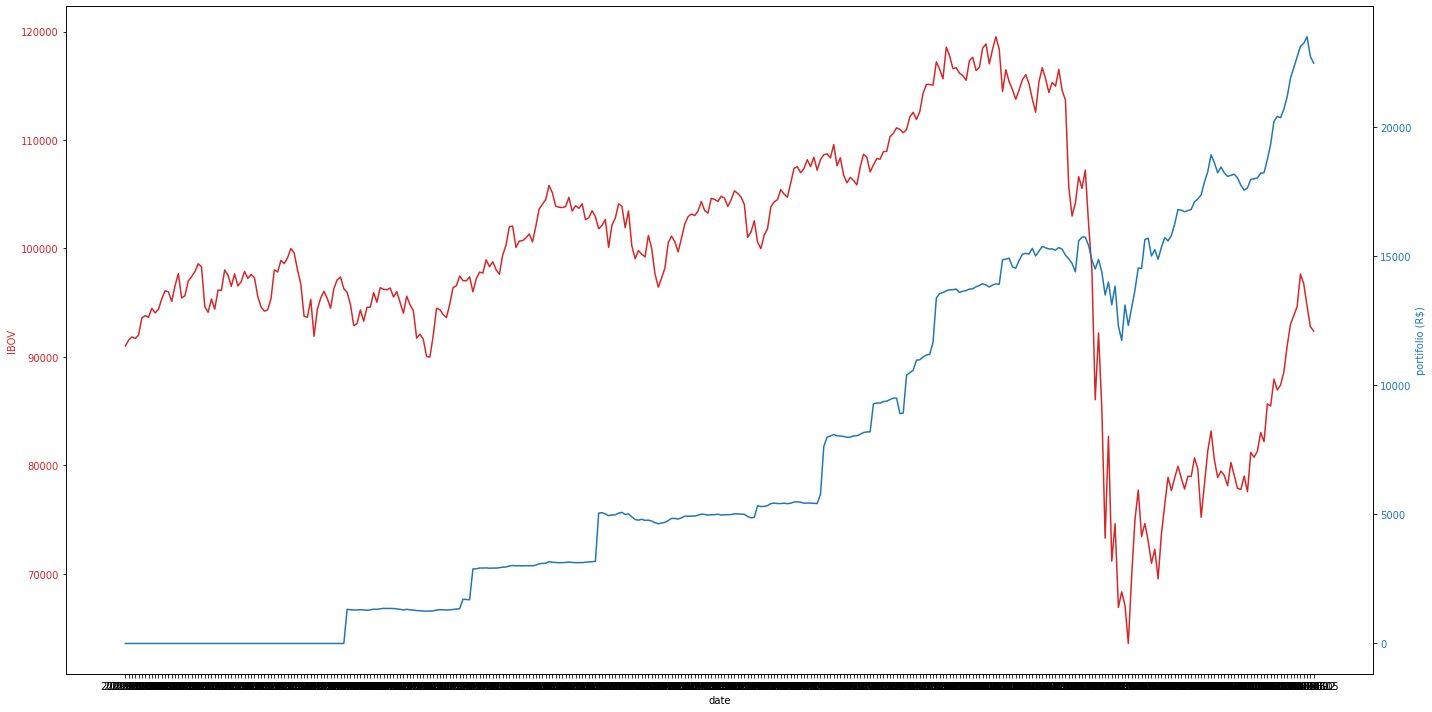

In [12]:
# get IBOV and total portifolio values over time

ibovPoints = []
portValuePoints = []

for day in days:
    ibovPoints.append(ibovData[day].closing)
    portValuePoints.append(portifolioDayValue[day])

plotTwoCurves(days, ibovPoints, 'IBOV', portValuePoints, 'portifolio (R$)')